# 04 Machine learning 01

During the machine learning phase, I do test multiple stratgies to solve the Jasscard Classifier task. The following task will be done:

1. CNN using image dimension of 32 * 32 (CNN32)
2. CNN using image dimension of 64 * 64 (CNN64)
3. CNN using image dimension of 224 * 224 (CNN224)
4. CNN with additinal data generation using image dimension of 32 * 32 (CNN32DG) and early stopping active
5. CNN with additinal data generation using image dimension of 64 * 64 (CNN64DG) and early stopping active
6. CNN with additinal data generation using image dimension of 224 * 224 (CNN224DG) and early stopping active
7. CNN with additinal data generation using image dimension of 32 * 32 (CNN32MA) and early stopping inactive
8. CNN with additinal data generation using image dimension of 64 * 64 (CNN64MA) and early stopping inactive
9. CNN with additinal data generation using image dimension of 224 * 224 (CNN224MA) and early stopping inactive

10. Pretrained model using image dimension of 224 * 224 and Random Forest classifier (RMF224PT)  
=> In separated jupiter notebook [04_Machine_learning_02](04_Machine_learning_02.ipynb)  
11. Pretrained model using image dimension of 224 * 224 and Random Forest classifier and Hyperparameter Tuning (RMF224PT)  
=> In separated jupiter notebook [04_Machine_learning_03](04_Machine_learning_03.ipynb)  


## Procedure
The list of model I'm going to train is represented in an Enumeration. The Enumerator name characterizes the Model by encoding the input shape and settings for data generation (DG) and Multiple Angle (MA/early stopping).

|Resolution\Type|CNN|DG|MA|
|-|-|-|-|
|32 x 32|CNN32|CNN32DG|CNN32MA|
|64 x 64|CNN64|CNN64DG|CNN64MA|
|224 x 224|CNN224|CNN224DG|CNN224DG|

* CNN regular with early stopping
* CNNDG with data generation and early stopping
* CNNMA with data generation and without early stopping

### Machine learning loop trough all defined models (Step 1)
### Display Overview Results (Step 2)
### Display Results of top 4 Models on Accuracy and loss (Step 3)
### Verification with Confusion Matrix on last Result (Step 4)
### Verification Step from loaded Data (Step 5)
### image diffuser result check (Step 6)
### Presentation of cardId distribution for train/test dataset (Step 7)


In [1]:
# Step 1
import JassSummarizer as js
from enum import Enum
from PIL import Image
import matplotlib.pyplot as plt 
from IPython.core.display import display, HTML
import json
import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import time
import re
import os
import cv2                                                                                  # computer vision python library see README.md dependencies


from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
import tensorflow as tf


cnnModels=Enum("cnnModels","CNN32,CNN64,CNN224,CNN32DG,CNN64DG,CNN224DG,CNN32MA,CNN64MA,CNN224MA",start=0)
cnnModels=Enum("cnnModels","CN32DG,CNN64,CNN64DG,CNN224",start=0)                                                 # current models to investigate
trainedDataPaths=["ii","iii","iv"]                                                          # maximal dataset definition
trainedDataPaths=["v"]                                                                      # current dataset definition
import cv2                                                                                  # computer vision python library see README.md dependencies
doFilePercent=100                                                                            # percentage of images to take for training
results= pd.DataFrame([])                                                                   # initialization for results
lastMode=0                                                                                  # remembers the lastMode of resolution used

# LOOP A for each defined model
for cnnModel in cnnModels:                                                                  # iterate trought the defined models
    mode=int(re.findall(r'\d+',cnnModel.name)[0])                                           # get the nummerical value
    subMode=cnnModel.name[-2:]                                                              # get subname of current model
    size = (mode, mode)                                                                     # define size from value
    mlDimension = (mode,mode,3)                                                             # define input shape from value
    fileListMaster= []                                                                      # variable to hold multiple fileliste if multiple dataset are choosen
    pathMaster="_"                                                                          # variable to hold pultiple dataset names/paths
    
    # LOOP B accumulates test data sets
    for dataPath in trainedDataPaths:                                                       # iterate trough data path
        path = os.path.join(r".\images\02_data_preparation", "train_datascan_"+dataPath)    # generate path
        pathMaster += dataPath                                                              # store pultiple dataset names/paths
        fileList = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if os.path.splitext(f)[1] == ".jpg"]

        if (doFilePercent !=100):                                                           # if not 100%
            a=fileList                                                                      # temporary variable
            random.shuffle(a)                                                               # shuffle them
            percent=int(len(fileList)/100*doFilePercent)                                    # take percentage of files
            fileList=a[0:percent]                                                           # store them back
            
        fileListMaster=fileListMaster+fileList                                              # accumulate
    path=pathMaster                                                                         # restore to standard variable
    fileList=fileListMaster                                                                 # restore to standard variable
    print(f"Analyzing Model {cnnModel.name}, by {mode}x{mode} with {len(fileList)} images | Time {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    time.sleep(0.3)
    
    if not ('X' in locals() and lastMode==mode and (len(X)+len(y) == 2*len(fileList))):
        X=[] ;y=[]                                                                              # initialize
        lastMode=mode                                                                           # remember mode which is currently loading/loaded

        # Loop C iterates through  all images
        with tqdm(total=len(fileList)) as pbar:                                                 # progressbar initialization
            for fName in fileList:                                                              # iterate trough files
                nameOnly=fName.split("\\")[-1]                                                  # take name
                cardId=nameOnly[0:2]                                                            # take caredId 
                myImage=cv2.imread(fName,cv2.IMREAD_COLOR)                                      # read image data
                data=js.analyzeScan(myImage,0.4)                                                # analyzeScan of image
                frameOrg,mask,img_rect,res,crop_img, d = data                                   # distribute results
                resized = cv2.resize(crop_img, size, interpolation = cv2.INTER_AREA)            # resize depending on current model
                r2=cv2.cvtColor(resized,cv2.COLOR_BGR2RGB)                                      # adjust color channels
                r3=js.backgroundDiffuser3(r2)                                                   # prevent black background
                X.append(r3)                                                                    # append trainings data
                y.append([js.JassCN2[cardId].value])                                            # append target
                pbar.update(1)                                                                  # update progress bar

    # split data into train , test and filetarget names,
    x_train_raw, x_test_raw, y_train_raw, y_test_raw = train_test_split(np.array(X),np.array(y,dtype="O"), test_size=0.2, random_state=42)    

    if subMode=="DG" or subMode=="MA":                                                       # submode MA = multiple angel
        train_generator = ImageDataGenerator(rescale=1/255,horizontal_flip=False,rotation_range=45, brightness_range=(0.5, 1.5),validation_split=0.2)
    else:                                                                                    # submode regular
        train_generator = ImageDataGenerator(rescale=1/255,horizontal_flip=False,validation_split=0.2)
    test_generator = ImageDataGenerator(rescale=1/255)                                       # normalize color values

    y_train = tf.keras.utils.to_categorical(y_train_raw, num_classes=36)                     # provide targets
    y_test = tf.keras.utils.to_categorical(y_test_raw, num_classes=36)                       # provide targets

    trainset = train_generator.flow(x_train_raw,y_train,shuffle=True,subset='training',batch_size=64)
    validset = train_generator.flow(x_train_raw,y_train,shuffle=False,subset='validation',batch_size=64)
    testset  =  test_generator.flow(x_test_raw,y_test,shuffle=False,batch_size=32)

    #y_train = tf.keras.utils.to_categorical(y_train_raw, num_classes=36)
    #y_test = tf.keras.utils.to_categorical(y_test_raw, num_classes=36)

    print('x_train.shape', x_train_raw.shape)                                                 # print current shapes
    print('x_test.shape', x_test_raw.shape)                                                   # print current shapes

    # define CNN layer 
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=2,activation='relu', input_shape=mlDimension))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(36, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["acc"])
    #model.summary()

    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
    if subMode=="MA":                                                                       # do use all epochs on submode MA
        hist = model.fit_generator(generator=trainset,validation_data=validset, verbose=0, epochs=150)
    else:                                                                                   # use early stopping if not submode MA
        hist = model.fit_generator(generator=trainset,validation_data=validset, verbose=0, epochs=150, callbacks=[early_stopping])

    x_train=x_train_raw/255                                                                 # recalculate
    x_test=x_test_raw/255                                                                   # recalculate
    loss, acc = model.evaluate(x_train, y_train, batch_size=250, verbose=0)                 # do it and store results for later use
    results=results.append( { "model": cnnModel.name ,"set":"train","loss": "{:.3f}".format(loss) , "acc": "{:.3f}".format(acc) 
            ,"x_loss": hist.history["loss"], "x_acc": hist.history["acc"],"val_loss": hist.history["val_loss"], "val_acc": hist.history["val_acc"] },ignore_index=True)
    loss, acc = model.evaluate(x_test, y_test, batch_size=250, verbose=0)
    results=results.append( { "model": cnnModel.name ,"set":"test","loss": "{:.3f}".format(loss) , "acc": "{:.3f}".format(acc) 
            ,"x_loss": hist.history["loss"], "x_acc": hist.history["acc"],"val_loss": hist.history["val_loss"], "val_acc": hist.history["val_acc"] },ignore_index=True)

    if 1==1:                                                                                # if desired save the train results/weights
        if not os.path.exists(r".\model_save"):
            os.mkdir(r".\model_save")        
        modelName=f"{cnnModel.name}_{path.split('_')[-1]}_{doFilePercent}"                  # identify running model to have facts in store name
        modelFile=os.path.join(r".\model_save",modelName)                                   # join parts
        model_json = model.to_json()                                                        # convert to json
        with open(modelFile+".json", "w") as json_file:                                     # get file handle
            json_file.write(model_json)                                                     # write it 
        model.save_weights(modelFile+".h5")                                                 # store weights
print(f"| Time {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
  

Analyzing Model CN32DG, by 32x32 with 69360 images | Time 2021-03-16 17:30:08


100%|███████████████████████████████████████████████████████████████████████████| 69360/69360 [07:09<00:00, 161.64it/s]


x_train.shape (55488, 32, 32, 3)
x_test.shape (13872, 32, 32, 3)
Analyzing Model CNN64, by 64x64 with 69360 images | Time 2021-03-16 18:05:10


100%|████████████████████████████████████████████████████████████████████████████| 69360/69360 [22:44<00:00, 50.85it/s]


x_train.shape (55488, 64, 64, 3)
x_test.shape (13872, 64, 64, 3)
Analyzing Model CNN64DG, by 64x64 with 69360 images | Time 2021-03-16 18:29:54
x_train.shape (55488, 64, 64, 3)
x_test.shape (13872, 64, 64, 3)
Analyzing Model CNN224, by 224x224 with 69360 images | Time 2021-03-16 18:56:50


100%|██████████████████████████████████████████████████████████████████████████| 69360/69360 [4:21:25<00:00,  4.42it/s]


x_train.shape (55488, 224, 224, 3)
x_test.shape (13872, 224, 224, 3)
| Time 2021-03-16 23:46:59


In [2]:
# Step 2
display(HTML("<h3>Accuracy results for trained models</h3>"))
results[results["set"] == "test"].sort_values(["acc"],ascending=False)[["model","acc","loss","set"]]

,model,acc,loss,set
7,CNN224,0.998,0.009,test
3,CNN64,0.996,0.018,test
5,CNN64DG,0.996,0.019,test
1,CN32DG,0.990,0.030,test


In [3]:
import winsound                                              # signalize accepted prediction
duration = 3000                                              # milliseconds
freq = 1440                                                  # Hz
winsound.Beep(freq, duration)  

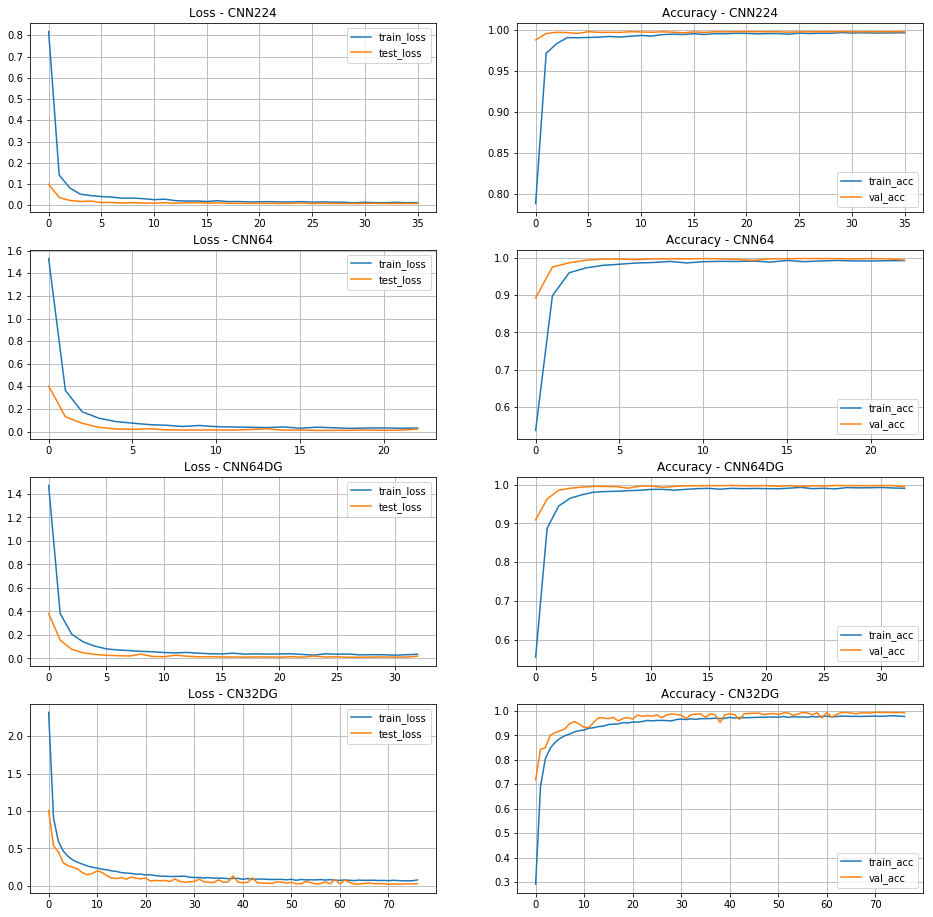

In [4]:
# Step 3
topCount= len(cnnModels) if len(cnnModels)<4 else 4
display(HTML(f"<h3>Top {topCount} models</h3>"))
resTopChart=results[results["set"] == "test"].sort_values(["acc"],ascending=False).head(4)
fig, axes = plt.subplots(nrows=topCount, ncols=2, figsize=[16, 16])
for j in range(0,topCount):
    resData=resTopChart[j:j+1]
    axes[j][0].plot(np.array(resData['x_loss'].values[0]), label="train_loss")
    axes[j][0].plot(np.array(resData['val_loss'].values[0]), label='test_loss')
    axes[j][0].set_title(f"Loss - {resData['model'].values[0]}")
    axes[j][0].legend()
    axes[j][0].grid()
    axes[j][1].plot(np.array(resData['x_acc'].values[0]), label='train_acc')
    axes[j][1].plot(np.array(resData['val_acc'].values[0]), label='val_acc')
    axes[j][1].set_title(f"Accuracy - {resData['model'].values[0]}")
    axes[j][1].legend()
    axes[j][1].grid()

In [5]:
# Step 4
from sklearn.metrics import confusion_matrix
pd.options.display.max_columns = None                                                       # disable hiding columns
display(HTML("<h1>Confusion Matrix</h1>"))                                                  # print title
test=[]                                                                                     # initialize array
for item in y_test:                                                                         # iterate trough test scores
    test=test+[item.argmax()]                                                               # store true value
y_predict=model.predict(x_test)                                                             # get prediction values
matrix = confusion_matrix(y_true=test, y_pred=np.argmax(y_predict, axis=1))                 # build matrix
cmDf=pd.DataFrame(matrix.astype("O"))                                                                       # as string type
cmDf=cmDf.replace(0,".")                                                                               # for better visualizing replace 0 with .
#cmDf=pd.DataFrame(matrix)                                                                   # store array in DataFrame
newColumn=[]                                                                                # generate new column
for card in js.JassCN2._member_names_:                                                      # iterate trough CardId keys
    newColumn=newColumn+[card]                                                              # add key

cmDf.columns=newColumn                                                                      # replaye column names
cmDf                                                                                        # print dataframe
cmDf.style.set_table_styles(                                                                # set stlye to support vertical alignment
    [dict(selector="th",props=[('max-width', '10px')]),
        dict(selector="th.col_heading",
                 props=[("writing-mode", "vertical-rl"), 
                        ('transform', 'rotateZ(-90deg)'),
                        ])])


,A0,A1,A2,A3,A4,A5,A6,A7,A8,B0,B1,B2,B3,B4,B5,B6,B7,B8,C0,C1,C2,C3,C4,C5,C6,C7,C8,D0,D1,D2,D3,D4,D5,D6,D7,D8
0,313,1,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
1,1,212,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
2,.,.,235,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
3,.,.,.,377,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
4,.,.,.,.,404,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
5,.,.,.,.,10,419,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,12,408,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,400,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,329,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
9,.,.,.,.,.,.,.,.,.,281,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.


# Verification Step from loaded Data

Too verify visualy was my code is doing, you can enable visual Check

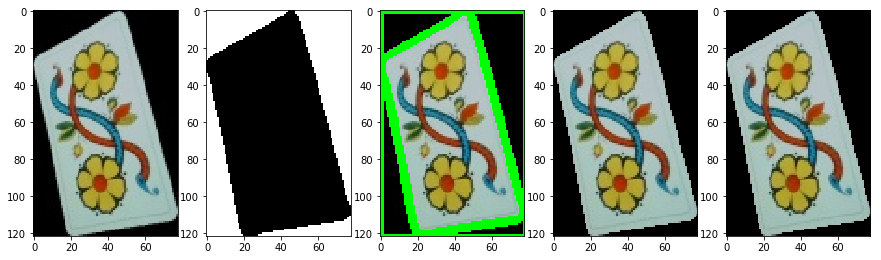

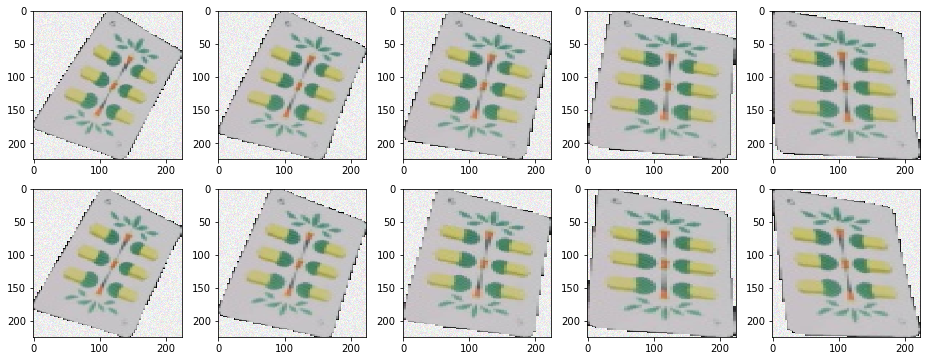

In [6]:
# Step 5
visualCheck= True
if visualCheck:
    display(HTML("<h1>analyzeImage result check"))
    fig=plt.figure(figsize=(15,15))
    i=col=1
    for item in data[0:-1]:
        temp=cv2.cvtColor(item,cv2.COLOR_BGR2RGB)
        fig.add_subplot(1, 5, i)
        plt.imshow(temp)
        i=i+1
    plt.show()
    
# Step 6
    display(HTML("<h1>image diffuser result check"))
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=[16, 6])
    for i in range(10):
        row=int(i/len(axes));    col=i%len(axes)
        axes[col,row].set_title("")
        axes[col,row].imshow(X[i])

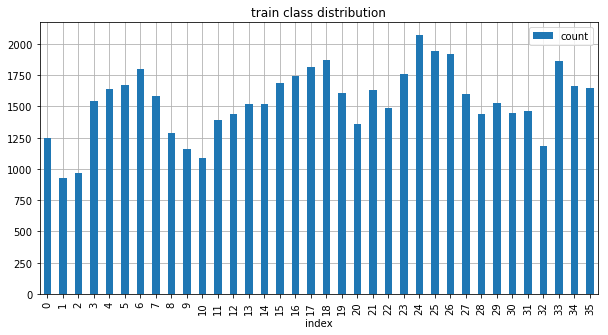

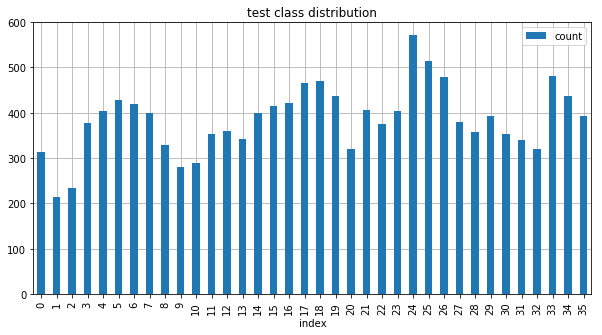

In [7]:
# Step 7
display(HTML("<h1>Distribution of cardId for train and test Data"))
pd.DataFrame(pd.Series(np.argmax(y_train,axis=1)).value_counts(),columns=["count"]).reset_index().sort_values("index").set_index("index").plot(kind="bar",
        grid=True,figsize=(10,5),title="train class distribution",zorder=10)
pd.DataFrame(pd.Series(np.argmax(y_test,axis=1)).value_counts(),columns=["count"]).reset_index().sort_values("index").set_index("index").plot(kind="bar",
        grid=True,figsize=(10,5),title="test class distribution",zorder=10)

In [8]:
if 1==2:
    modelName=f"{cnnModel.name}_{path.split('_')[-1]}_{doFilePercent}"
    modelFile=os.path.join(r".\model_save",modelName)
    model_json = model.to_json()
    with open(modelFile+".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(modelFile+".h5")

In [10]:
if 1==1:
    results.to_csv(f"ML_results_{path.split('_')[-1]}_{doFilePercent}.csv",index=False)